In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_svhn
from models import DomainAdaptationNetwork, get_simple_classifier, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_tsne

In [2]:
torch.manual_seed(1)
import numpy as np
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(self.conv_feat_size[0], out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=nb_channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(nb_channels, out_channels=32, kernel_size=5, padding=2),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=2048)
        self.task_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target        

In [4]:
target_train_loader, target_test_loader = load_mnist(img_size=32, batch_size=128, shuffle=True, num_workers=4)
source_train_loader, source_test_loader = load_svhn(img_size=(32, 32), batch_size=128, split=1, shuffle=True, num_workers=4)

learning_rate = 5e-4
#epochs=10
epochs=30

encoder = Encoder(latent_space_dim=75, img_size=(3,32,32), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
decoder_target = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=1)
classifier = get_simple_classifier(latent_space_dim=75)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = ProjectorNetwork(latent_dim=75).cuda()
betas = np.ones(30) * 10
betas[:10] = np.linspace(0, 10, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas,
                                            epochs=epochs, alpha=1, delta=0.1, gamma=1, show_images=False)

Using downloaded and verified file: ../data/train_32x32.mat


  0%|          | 0/30 [00:00<?, ?it/s]/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch:0 current target accuracy:45.15%:   3%|▎         | 1/30 [00:33<16:07, 33.37s/it]

epoch [1/30], loss:1.4664
accuracy source: 76.57%
accuracy target: 45.18%


epoch:1 current target accuracy:77.91%:   7%|▋         | 2/30 [01:08<15:46, 33.81s/it]

epoch [2/30], loss:1.3167
accuracy source: 87.45%
accuracy target: 77.95%


epoch:2 current target accuracy:84.18%:  10%|█         | 3/30 [01:43<15:21, 34.14s/it]

epoch [3/30], loss:1.1516
accuracy source: 90.42%
accuracy target: 84.23%


epoch:3 current target accuracy:87.4%:  13%|█▎        | 4/30 [02:17<14:46, 34.10s/it] 

epoch [4/30], loss:1.0853
accuracy source: 91.84%
accuracy target: 87.44%


epoch:4 current target accuracy:88.11%:  17%|█▋        | 5/30 [02:52<14:18, 34.35s/it]

epoch [5/30], loss:1.0445
accuracy source: 92.65%
accuracy target: 88.16%


epoch:5 current target accuracy:88.68%:  20%|██        | 6/30 [03:26<13:46, 34.44s/it]

epoch [6/30], loss:1.0063
accuracy source: 93.42%
accuracy target: 88.73%


epoch:6 current target accuracy:88.63%:  23%|██▎       | 7/30 [04:00<13:07, 34.25s/it]

epoch [7/30], loss:0.9805
accuracy source: 94.05%
accuracy target: 88.68%


epoch:7 current target accuracy:89.73%:  27%|██▋       | 8/30 [04:33<12:27, 33.97s/it]

epoch [8/30], loss:0.9608
accuracy source: 94.46%
accuracy target: 89.78%


epoch:8 current target accuracy:89.82%:  30%|███       | 9/30 [05:07<11:51, 33.86s/it]

epoch [9/30], loss:0.9396
accuracy source: 95.0%
accuracy target: 89.86%


epoch:9 current target accuracy:90.61%:  33%|███▎      | 10/30 [05:41<11:16, 33.81s/it]

epoch [10/30], loss:0.9246
accuracy source: 95.32%
accuracy target: 90.66%


epoch:10 current target accuracy:91.15%:  37%|███▋      | 11/30 [06:14<10:39, 33.68s/it]

epoch [11/30], loss:0.9066
accuracy source: 95.6%
accuracy target: 91.2%


epoch:11 current target accuracy:92.2%:  40%|████      | 12/30 [06:48<10:05, 33.65s/it] 

epoch [12/30], loss:0.8829
accuracy source: 95.97%
accuracy target: 92.25%


epoch:12 current target accuracy:94.3%:  43%|████▎     | 13/30 [07:21<09:30, 33.58s/it] 

epoch [13/30], loss:0.8723
accuracy source: 96.25%
accuracy target: 94.35%


epoch:13 current target accuracy:95.45%:  47%|████▋     | 14/30 [07:55<08:57, 33.59s/it]

epoch [14/30], loss:0.8607
accuracy source: 96.43%
accuracy target: 95.5%


epoch:14 current target accuracy:95.44%:  50%|█████     | 15/30 [08:28<08:23, 33.59s/it]

epoch [15/30], loss:0.8484
accuracy source: 96.58%
accuracy target: 95.49%


epoch:15 current target accuracy:95.66%:  53%|█████▎    | 16/30 [09:02<07:49, 33.57s/it]

epoch [16/30], loss:0.8368
accuracy source: 96.91%
accuracy target: 95.71%


epoch:16 current target accuracy:95.56%:  57%|█████▋    | 17/30 [09:35<07:15, 33.51s/it]

epoch [17/30], loss:0.8258
accuracy source: 97.12%
accuracy target: 95.61%


epoch:17 current target accuracy:95.57%:  60%|██████    | 18/30 [10:09<06:42, 33.51s/it]

epoch [18/30], loss:0.8237
accuracy source: 97.06%
accuracy target: 95.62%


epoch:18 current target accuracy:95.71%:  63%|██████▎   | 19/30 [10:42<06:08, 33.48s/it]

epoch [19/30], loss:0.8246
accuracy source: 97.02%
accuracy target: 95.76%


epoch:19 current target accuracy:95.94%:  67%|██████▋   | 20/30 [11:15<05:34, 33.48s/it]

epoch [20/30], loss:0.8161
accuracy source: 97.19%
accuracy target: 95.99%


epoch:20 current target accuracy:95.96%:  70%|███████   | 21/30 [11:49<05:01, 33.49s/it]

epoch [21/30], loss:0.8080
accuracy source: 97.41%
accuracy target: 96.01%


epoch:21 current target accuracy:96.22%:  73%|███████▎  | 22/30 [12:22<04:27, 33.49s/it]

epoch [22/30], loss:0.8041
accuracy source: 97.55%
accuracy target: 96.27%


epoch:22 current target accuracy:96.45%:  77%|███████▋  | 23/30 [12:56<03:54, 33.46s/it]

epoch [23/30], loss:0.8053
accuracy source: 97.44%
accuracy target: 96.5%


epoch:23 current target accuracy:96.45%:  80%|████████  | 24/30 [13:29<03:20, 33.47s/it]

epoch [24/30], loss:0.7974
accuracy source: 97.65%
accuracy target: 96.5%


epoch:24 current target accuracy:96.59%:  83%|████████▎ | 25/30 [14:03<02:47, 33.49s/it]

epoch [25/30], loss:0.7933
accuracy source: 97.7%
accuracy target: 96.64%


epoch:25 current target accuracy:96.77%:  87%|████████▋ | 26/30 [14:36<02:13, 33.41s/it]

epoch [26/30], loss:0.7944
accuracy source: 97.71%
accuracy target: 96.82%


epoch:26 current target accuracy:96.82%:  90%|█████████ | 27/30 [15:10<01:40, 33.43s/it]

epoch [27/30], loss:0.7947
accuracy source: 97.64%
accuracy target: 96.87%


epoch:27 current target accuracy:96.82%:  93%|█████████▎| 28/30 [15:43<01:06, 33.44s/it]

epoch [28/30], loss:0.7953
accuracy source: 97.67%
accuracy target: 96.87%


epoch:28 current target accuracy:97.07%:  97%|█████████▋| 29/30 [16:17<00:33, 33.45s/it]

epoch [29/30], loss:0.7873
accuracy source: 97.83%
accuracy target: 97.12%


epoch:29 current target accuracy:97.48%: 100%|██████████| 30/30 [16:50<00:00, 33.69s/it]

epoch [30/30], loss:0.7803
accuracy source: 97.98%
accuracy target: 97.53%


In [5]:
model.eval()
test_network(model, target_test_loader)

0.9806

In [6]:
import matplotlib.pyplot as plt
def plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader):
    X, _ = next(iter(target_train_loader))
    y, _, (z_share, z_spe),  _ = model(X.cuda(), mode='all_target')
    X2, _ = next(iter(source_train_loader))
    _, _, (z_share, _),  _ = model(X2.cuda(), mode='all_target')
    #blank
    plt.subplot(1,6,1)
    plt.imshow(torch.ones((32,32,3)))
    plt.axis('off')
    plt.tight_layout()
    #styles
    for i in range(5):
        plt.subplot(1,6,i+2)
        plt.imshow(X[i].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

    for j in range(10, 20):
        plt.figure()
        plt.subplot(1,6,1)
        plt.imshow(X2[j].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

        z_x = torch.zeros_like(z_share)
        z_x[:] = z_share[j]
        y2  = model.decoder_target(z_x, z_spe)
        for i in range(5):
            plt.subplot(1,6,i+2)
            plt.imshow(y2[i].cpu().detach().permute(1, 2, 0))
            plt.axis('off')
            plt.tight_layout()

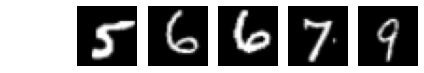

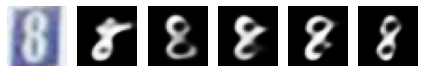

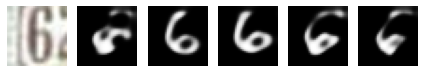

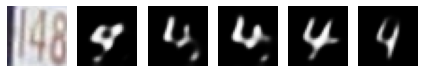

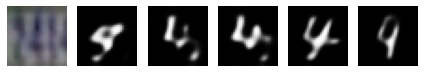

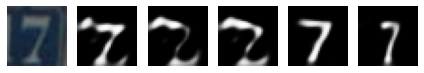

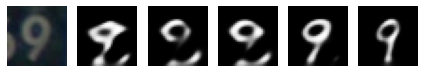

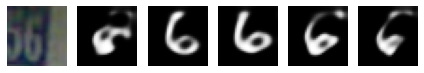

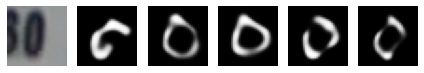

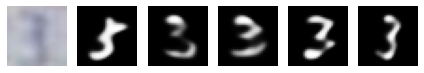

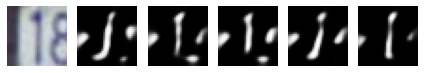

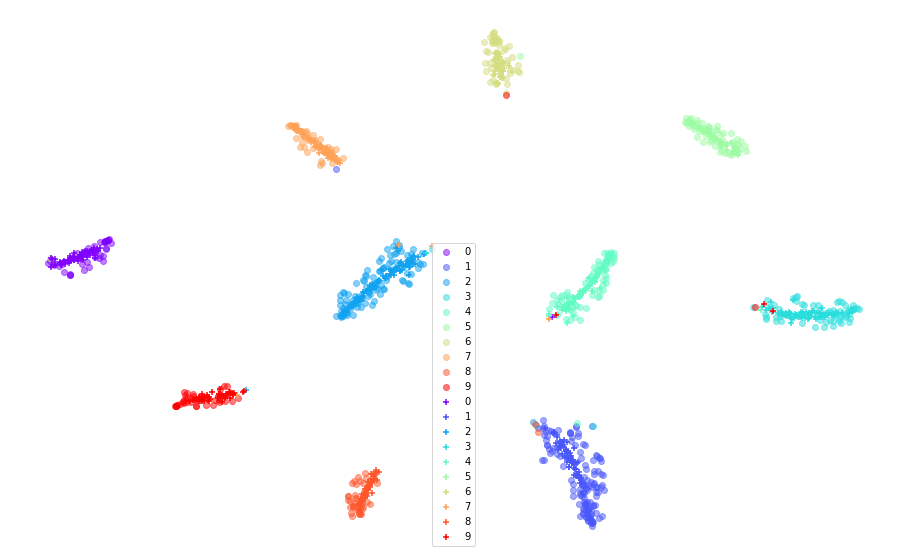

In [9]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, 128, 75)